In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import random
import pickle
import seaborn as sns
sns.set()
from copy import deepcopy
import datetime
from haversine import haversine

import warnings;warnings.simplefilter('ignore')
xgb_model = pickle.load(open('xgb_model.sav', 'rb'))

[13:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [42]:
class Chromosome:
    """
    Class to build chromosome specified for TSP problem. It makes use 
    of pandas dataframe to keep the locations (latitudes, logitudes)
    and their order.
    """
    def __init__(self, locations):
        self.df = pd.DataFrame(columns=['x','y'])
        for location in locations:
            self.df = self.df.append(location, ignore_index=True)
            
    def Shuffle(self, order=None):
        """
        shuffle the dataframe if the order is not given
        """
        if not order:
            order = self.Path
            random.shuffle(order)
        self.df = self.df.reindex(order)
        
    @property
    def Path(self):
        """
        returns the order of visiting locations
        """
        return self.df.index.tolist().copy()
    
    def CrossOver_1(self):
        """
        Substitute elements pairwise from begining 
        """
        order = self.Path
        for i in range(1,len(order)):
            if (i%2 == 1):
                order[i], order[i-1] = order[i-1], order[i]
        self.Shuffle(order)
    
    def CrossOver_2(self):
        """
        Split total path into two parts, then replace them with each other
        """
        order = self.Path
        middle = int(len(order)/2)
        for i in range(middle):
            order[i], order[i+middle] = order[i+middle], order[i]
        self.Shuffle(order)
    
    def Mutate(self, n_mut):
        """
        Selects random locations from path and substitute them with
        each other
        """
        order = self.Path
        mutated = random.choices(order, k=n_mut)
        for i in range(len(mutated)):
            if i%2==0:
                order[mutated[i]], order[mutated[i+1]] = order[mutated[i+1]], order[mutated[i]]
        self.Shuffle(order)
    
    @property
    def Fitness(self):
        """
        Calculates the total cost of traveling through whole path
        """
        passenger_count=1
        store_and_fwd_flag=0
        date_list = [27, 5, 2016]
        year = int(date_list[2])
        month = int(date_list[1])
        day = int(date_list[0])
        my_date = datetime.date(year, month, day)
        
        data = []
        for  index in range(1,self.df.shape[0]):
            p_x = self.df.x.iloc[index-1]
            p_y = self.df.y.iloc[index-1]
            
            d_x = self.df.x.iloc[index]
            d_y = self.df.y.iloc[index]
            
            model_data = {
                    'passenger_count': passenger_count,'pickup_longitude': p_x,
                    'pickup_latitude': p_y,'dropoff_longitude': d_x,
                    'dropoff_latitude': d_y,'store_and_fwd_flag': bool(store_and_fwd_flag),
                    'pickup_month': my_date.month,'pickup_day': my_date.day,
                    'pickup_weekday': my_date.weekday(),'pickup_hour': 11,
                    'pickup_minute': 0,'latitude_difference': p_x - d_x,
                    'longitude_difference': p_y - d_y,'distance': haversine((p_x,p_y), (d_x, d_y))
                    }
            data.append(model_data)
                
        p_x = self.df.x.iloc[-1]
        p_y = self.df.y.iloc[-1]

        d_x = self.df.x.iloc[0]
        d_y = self.df.y.iloc[0]
        model_data = {
            'passenger_count': passenger_count,'pickup_longitude': p_x,
            'pickup_latitude': p_y,'dropoff_longitude': d_x,
            'dropoff_latitude': d_y,'store_and_fwd_flag': bool(store_and_fwd_flag),
            'pickup_month': my_date.month,'pickup_day': my_date.day,
            'pickup_weekday': my_date.weekday(),'pickup_hour': 11,
            'pickup_minute': 0,'latitude_difference': p_x - d_x,
            'longitude_difference': p_y - d_y,'distance': haversine((p_x,p_y),(d_x, d_y)),
        }
        data.append(model_data)
        
        df = pd.DataFrame(data, columns=model_data.keys())
        preds = np.exp(xgb_model.predict(xgb.DMatrix(df))) - 1
        return preds.sum()
    
    def Plot(self):
        """
        Ploting the traveling path according to visiting order of locations.
        """
        plt.figure(figsize=(10,10))
        ax = self.df.plot.scatter('x', 'y', title='TOTAL PATH='+str(self.Path), figsize=(8,8))
        
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        
        for i in range(self.df.shape[0]):
            ax.annotate(i, (self.df.x.iloc[i], self.df.y.iloc[i]), fontsize=30)
            
        def drawArrow(A, B, color='r'):
            plt.arrow(A.x, A.y, B.x-A.x, B.y-A.y, width=0.0003, color=color, length_includes_head=True)

        for i in range(1,len(self.df)):
            drawArrow(self.df.iloc[i-1], self.df.iloc[i], 'r')
            
        drawArrow(self.df.iloc[-1], self.df.iloc[0], 'b')
        plt.show()

In [43]:
def calc_distance(loc1, loc2):
    # Calculate distance between two locations
    start = (loc1['x'], loc1['y'])
    end = (loc2['x'], loc2['y'])
    return haversine(start, end)

def fitness(elem):
    return elem[1]

# Parameters for Genetic Algorithm

In [45]:
class GeneticOptimizer:
    def __init__(self, csv_file="test.csv", 
                 num_locations=15, populations=10, generations=100,
                 mutation_rate=0.2, keep_rate=0.4) -> None:
        """
        num_location -> It is the size of chromosome | how many location you want to add to path
        populations -> The number of chromosomes
        generations -> number of epochs
        mutation_rate -> what percentage of population have to be mutated?| between 0 and 1
        keep_rate -> what percentage of populations have to be kept?| between 0 and 1
        
        """
        self.num_locations = num_locations
        self.populations = populations
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.keep_rate = keep_rate
        self.data = pd.read_csv(csv_file)
        self.locations = []
        self.chromosomes = []
        self.prepare()
        print('Prepared!')
        
    def prepare(self)->None:
        """Initialize first generations"""
        start = 0
        samples = self.data.iloc[start:start+self.num_locations].reset_index(drop=True)
        temp = {}
        for i in range(samples.shape[0]):
            x = samples.iloc[i].pickup_longitude
            y = samples.iloc[i].pickup_latitude
            self.locations.append({'x':x, 'y':y})
    
        self.chromosomes = []
        for i in range(self.populations):
            chm = Chromosome(self.locations)
            chm.Shuffle()
            self.chromosomes.append([chm, chm.Fitness])
        self.chromosomes.sort(key=fitness)

    def run(self)->list:
        """Run the algorithm"""
        # results -> keep track of best result of each generation
        
        results = []
        n_keep = int(self.keep_rate * self.populations)
        
        for epoch in range(self.generations):
            # Keep the best one
            results.append(self.chromosomes[0][1])
            for i in range(n_keep,self.populations):
                parent = deepcopy(random.choice(self.chromosomes[0:n_keep])[0])
                parent.CrossOver_1()
                self.chromosomes[i] = [parent, parent.Fitness]
            
            # Mutate the population
            for i in range(1,self.populations):
                m = random.random()
                if m <= self.mutation_rate:
                    self.chromosomes[i][0].Mutate(6)
                    self.chromosomes[i][1] = self.chromosomes[i][0].Fitness
                    
            # Sort the chromosomes based on fitness function
            self.chromosomes.sort(key=fitness)
            
            # Is is optimized?
            if self.chromosomes[0][1] < min(results):
                print('Path optimized to ', self.chromosomes[0][1], ' at epoch = ', epoch)
            
            
        return results
    @staticmethod
    def plot(results):
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.plot(results)
 
    def map_plot(self):
        self.chromosomes[0][0].Plot()

## Run the program

In [52]:
args = {'populations':40, 'num_locations':10,
        'generations':200, 'mutation_rate':0.2,
        'keep_rate':0.4, 'csv_file':"test.csv"}

agent = GeneticOptimizer(**args)
results = agent.run()

Prepared!
Path optimized to  138.2481  at epoch =  3
Path optimized to  136.23232  at epoch =  15
Path optimized to  125.69333  at epoch =  16
Path optimized to  119.03181  at epoch =  84
Path optimized to  114.12848  at epoch =  134


## How algorithm optimized cost through iterations.

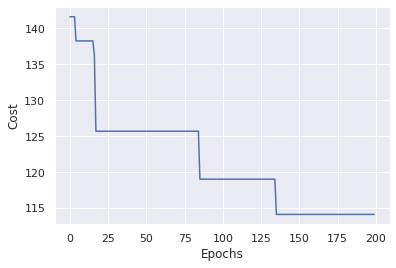

In [53]:
GeneticOptimizer.plot(results)

# The best path found

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 720x720 with 0 Axes>

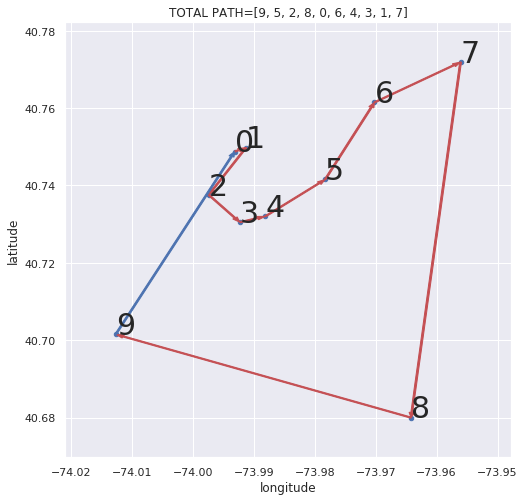

In [54]:
agent.map_plot()